Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

In [1]:
!git clone https://github.com/quentgar/dip-inpainting-registration
!mv dip-inpainting-registration/* ./

Cloning into 'dip-inpainting-registration'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (125/125), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 686 (delta 51), reused 0 (delta 0), pack-reused 561
Receiving objects: 100% (686/686), 78.13 MiB | 29.47 MiB/s, done.
Resolving deltas: 100% (304/304), done.


In [2]:
pip install voxelmorph

     |████████████████████████████████| 75 kB 3.1 MB/s 
     |████████████████████████████████| 86 kB 4.8 MB/s 


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:214: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


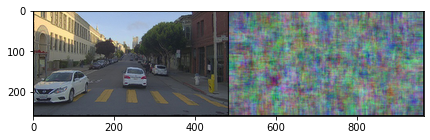

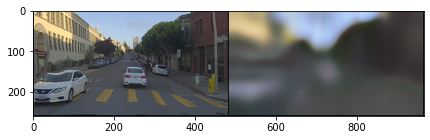

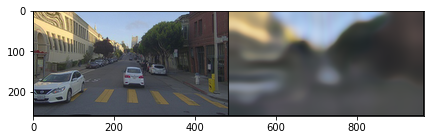

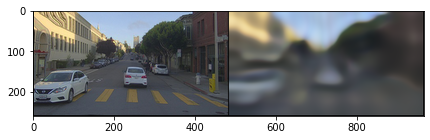

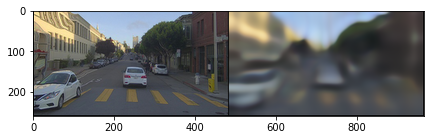

KeyboardInterrupt: ignored

In [6]:
# -*- coding: utf-8 -*-
"""load_video_images.ipynb
Automatically generated by Colaboratory.
Original file is located at
    https://colab.research.google.com/drive/16I3Giqlru_5NrrjNZXeHSnAOre0YT4fF
"""

#!git clone https://github.com/quentgar/dip-inpainting-registration.git
#!mv dip-inpainting-registration/* ./

#pip install voxelmorph

# Commented out IPython magic to ensure Python compatibility.
from __future__ import print_function
import matplotlib.pyplot as plt
# %matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from src.utils import *
from src.hourglass_network import *
import torch
import torch.optim

from skimage.measure import compare_psnr

from voxelmorph.torch.layers import SpatialTransformer
import seaborn as sns

import cv2
from PIL import Image

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize = -1
dim_div_by = 32

img_path = 'mydata/city/'
mask_path = 'mydata/city/mask_phare/mask_'

ind_debut = 0
ind_fin = 19

img_path1 = img_path + "0" + str(ind_debut) + ".jpg"
mask_path1 = mask_path + "0" + str(ind_debut+1) + '.jpg'

img_np1 = format_image(img_path1, dim_div_by)
mask_np1 = format_image(mask_path1, dim_div_by)
size = img_np1.shape[1:]

"""
r = np.where((img_np1[0,:,:] > 0.5) & (img_np1[1,:,:] > 0.5) & (img_np1[2,:,:] > 0.5), 0, 1)
t = np.array(r,dtype=float)
res = cv2.resize(t,None,fx=0.1,fy=0.1,interpolation=cv2.INTER_AREA)
res2 = cv2.resize(res,None,fx=10,fy=10,interpolation=cv2.INTER_CUBIC)
a = np.where(res2 > 0.9, 1, 0)
a = np.array(a,dtype=float)
mask_tmp = np.repeat(a[..., np.newaxis], 3, axis=2)
mask_tmp = mask_tmp.transpose(2,0,1)
mask_np1 = crop_perso(mask_tmp, dim_div_by)"""

"""## Création du réseau"""

INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 2500
show_every = 50
figsize = 5
reg_noise_std = 0.03
depth = 5

"""
net = build_hourglass(input_depth, output_depth=img_np1.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [4]*depth,  
               filter_size_up = 5, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)
net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)
"""
# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var1 = np_to_torch(img_np1).type(dtype)
mask_var1 = np_to_torch(mask_np1).type(dtype)

i = 0
list_iter = []
list_psnr = []
list_loss = []

def closure_inp():
    
    global i, list_iter, list_psnr, list_loss
    
    net_input = net_input_saved + (noise.normal_() * reg_noise_std)
       
    out = net(net_input)
   
    total_loss = mse(out * mask_var1, img_var1 * mask_var1)
    total_loss.backward()
        
    if PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        out_np = torch_to_np(out)
        list_iter.append(i)
        #list_psnr.append(compare_psnr(img_np1,out_np))
        list_loss.append(total_loss.item())
        #plt.imshow(out_np.transpose(1,2,0))
        #plt.show()
        #plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss
"""
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
p = get_params(net)
optimize(p, closure_inp, LR, num_iter)
plt.figure()
plt.plot(list_iter,list_loss)
plt.show()
#PATH = "/home/francois/dip-registration/model.pt"
#net.load_state_dict(torch.load(PATH),strict=False)
res1 = torch_to_np(net(net_input))
t = res1.transpose(1,2,0)*255
im = Image.fromarray(t.astype(np.uint8))
im.save('res0.jpg')
#torch.save(net,PATH)
"""

#img_prec_var = net(net_input).detach().clone()
img_prec_var = img_var1
num_iter = 2500

LR_inp = 0.001
LR_rec = 0.1

for j in range(ind_debut+1, ind_fin+1):

  # Masque et image 2
  if j < 10:
      c = "0"
  else:
      c = ""

  img2_path = img_path + c + str(j) + '.jpg'
  mask2_path = mask_path + c + str(j) + '.jpg'

  img_np2 = format_image(img2_path, dim_div_by)
  mask_np2 = format_image(mask2_path, dim_div_by)

  # Création des réseaux 
  net_recalage = build_hourglass(input_depth, output_depth=2, 
            num_channels_down = [128]*depth,
            num_channels_up =   [128]*depth,
            num_channels_skip =    [4]*depth,  
            filter_size_up = 3, filter_size_down = 3, 
            up_samp_mode='nearest', filter_skip_size=1,num_scales=depth,need_sigmoid=False).type(dtype)

  net_inpainting = build_hourglass(input_depth, output_depth=img_np1.shape[0], 
               num_channels_down = [128]*depth,
               num_channels_up =   [128]*depth,
               num_channels_skip =    [0]*depth,  
               filter_size_up = 5, filter_size_down = 5, 
               up_samp_mode='nearest', filter_skip_size=1,num_scales=depth).type(dtype)

  net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)
  #net_input.div_(10)

  # Spatial transformer
  transformer = SpatialTransformer(size)

  # Création des tenseurs

  img_var2 = np_to_torch(img_np2).type(dtype)
  mask_var2 = np_to_torch(mask_np2).type(dtype)

  i = 0
  list_iter = []
  list_loss = []

  best_loss = 10
  best_iter = 0
  best_out = None
  best_flow = None

  l1 = 1
  l2 = 3
  psnr_last = 0
    
  def closure():
      
      global i, list_iter, list_loss, inp_prec, flow_prec, best_loss, best_iter, best_out, best_flow, psnr_last
      
      net_input = net_input_saved + (noise.normal_() * reg_noise_std)

      inp_prec = net_inpainting(net_input)
      flow_prec = net_recalage(net_input)
      
      out_trans = transformer(img_prec_var.type(torch.FloatTensor),flow_prec.type(torch.FloatTensor)).type(dtype)
    
      total_loss = l1*mse(out_trans, inp_prec) + l2*mse(inp_prec * mask_var2, img_var2 * mask_var2)
      total_loss.backward()
    
      psrn_gt = compare_psnr(img_np2 * mask_np2, inp_prec.detach().cpu().numpy()[0] * mask_np2)

      if total_loss.item() < best_loss:
        best_loss = total_loss.item()
        best_iter = i
        best_out_trans = out_trans
        best_out_inp = inp_prec
        best_flow = flow_prec
          
      if PLOT and i % show_every == 0:
          print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
          
          list_iter.append(i)
          list_loss.append(total_loss.item())
          #plt.imshow(out_np.transpose(1,2,0))
          #plt.show()
          plot_image_grid([np.clip(torch_to_np(out_trans), 0, 1), np.clip(torch_to_np(inp_prec), 0, 1)], factor=5, nrow=2)
            
            
      # Backtracking
      if i % show_every:
            if psrn_gt - psnr_last < -3: 
                print('Falling back to previous checkpoint.')

                for new_param, net_param in zip(last_net_inp, net_inpainting.parameters()):
                    net_param.data.copy_(new_param.cuda())

            i += 1

            return total_loss*0
      else:
        last_net_inp = [x.detach().cpu() for x in net_inpainting.parameters()]
        psrn_last = psrn_gt
        
          
      i += 1

      return total_loss

  net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)

  net_input_saved = net_input.detach().clone()
  noise = net_input.detach().clone()

  p1 = get_params(net_inpainting)
  p2 = get_params(net_recalage)

  optimize_joint(p1, p2, closure, LR_inp, LR_rec, num_iter)

  img_prec_var = net_inpainting(net_input).detach().clone()
  img_np = torch_to_np(img_prec_var)

  t = img_np.transpose(1,2,0)*255
  im = Image.fromarray(t.astype(np.uint8))
  im.save('res/test_phare3/res'+str(j)+'.jpg')